In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install torch==1.12.0+cpu torchvision==0.13.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# !pip install --upgrade torch==2.2.1

In [ ]:
!mkdir jpg

In [ ]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

In [ ]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

In [ ]:
class Fusion:
    def __init__(self, input):

        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):

        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]

        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.

        self._tranfer_to_tensor()

        fused_img = self._fuse()[:, :, 0]

        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)


    def _fuse(self):

        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output


    def _RGB_to_YCbCr(self, img_RGB):

            img_RGB = img_RGB.astype(np.float32) / 255.
            return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):

            img_YCbCr = img_YCbCr.astype(np.float32)
            return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):

            if len(img.shape) < 3:
                return True
            if img.shape[2] == 1:
                return True
            b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
            if (b == g).all() and (b == r).all():
                return True
            return False

    def _softmax(self, tensor):

            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):

            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input))

In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

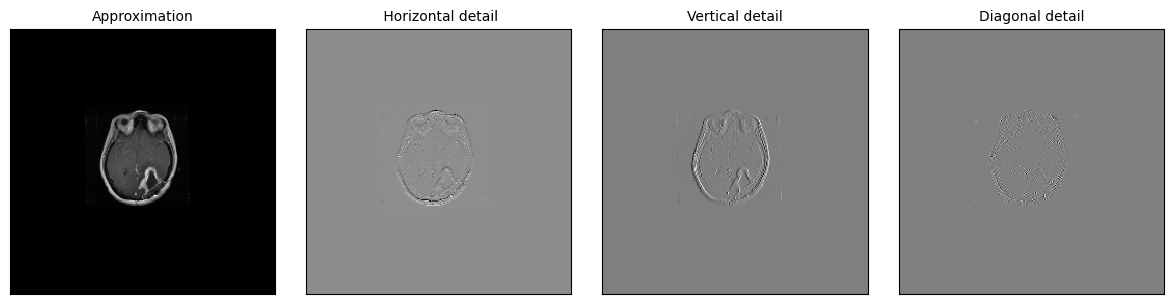

In [ ]:
mri_image = cv2.imread('/content/drive/MyDrive/Project/Inputs/MRI_REGISTERED/mri_registered1.jpg')
mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(mri_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='/content/jpg/mri_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

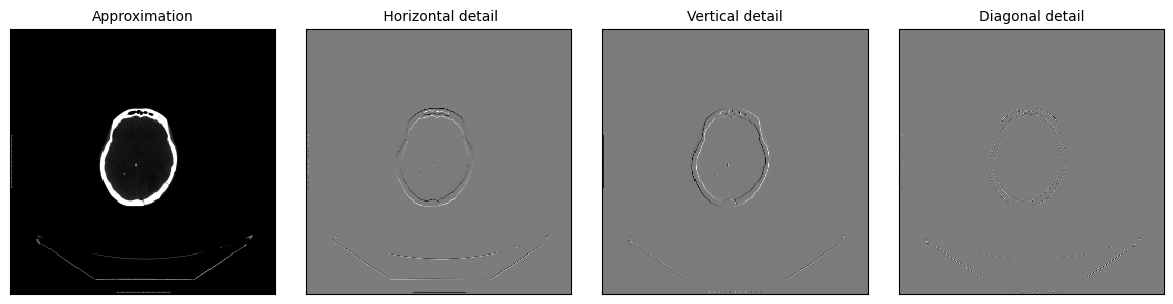

In [ ]:
ct_image = cv2.imread('/content/drive/MyDrive/Project/Inputs/CT_pre-processed/ct1.jpg')
ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(ct_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='/content/jpg/ct_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
input_images = []
mri = cv2.imread('/content/jpg/mri_0.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/jpg/ct_0.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

FU = Fusion(input_images)
fusion_img = FU.fuse()

cv2.imwrite('/content/jpg/fusion_0.jpg', fusion_img)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 61.6MB/s]


True

In [ ]:
input_images = []
mri = cv2.imread('/content/jpg/mri_1.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/jpg/ct_1.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

FU = Fusion(input_images)
fusion_img = FU.fuse()

cv2.imwrite('/content/jpg/fusion_1.jpg', fusion_img)

True

In [ ]:
input_images = []
mri = cv2.imread('/content/jpg/mri_2.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/jpg/ct_2.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

FU = Fusion(input_images)
fusion_img = FU.fuse()

cv2.imwrite('/content/jpg/fusion_2.jpg', fusion_img)

True

In [ ]:
input_images = []
mri = cv2.imread('/content/jpg/mri_3.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('/content/jpg/ct_3.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

FU = Fusion(input_images)
fusion_img = FU.fuse()

cv2.imwrite('/content/jpg/fusion_3.jpg', fusion_img)

True

In [ ]:
fusion_0 = cv2.imread('/content/jpg/fusion_0.jpg')
fusion_0 = cv2.cvtColor(fusion_0, cv2.COLOR_BGR2GRAY)

fusion_1 = cv2.imread('/content/jpg/fusion_1.jpg')
fusion_1 = cv2.cvtColor(fusion_1, cv2.COLOR_BGR2GRAY)

fusion_2 = cv2.imread('/content/jpg/fusion_2.jpg')
fusion_2 = cv2.cvtColor(fusion_2, cv2.COLOR_BGR2GRAY)

fusion_3 = cv2.imread('/content/jpg/fusion_3.jpg')
fusion_3 = cv2.cvtColor(fusion_3, cv2.COLOR_BGR2GRAY)

coeffs=(fusion_0,(fusion_1,fusion_2,fusion_3))

In [ ]:
fusion=pywt.idwt2(coeffs,'haar')
cv2.imwrite('/content/drive/MyDrive/Project/folder/fused/fusion1.jpg',fusion)

True

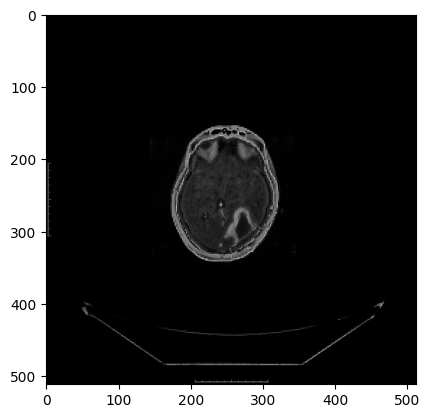

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(fusion, cmap='gray', vmin=0, vmax=255)